# Sequence processing with convnets

Implementing a 1D convnet
In Keras, we will use a 1D convnet via the Conv1D layer, which has a very similar interface to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the Netflix Reviews sentiment classification task .

As a reminder, this is the code for obtaining and preprocessing the data:

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix_reviews.csv


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Netflix Reviews Playstore Dataset Description

This dataset contains daily updated reviews and metadata for the Netflix app on the Google Play Store. It includes user ratings, review texts, and additional details such as the review date, user location, and app version. This data is ideal for various analyses, including sentiment analysis, user behavior analysis, and app performance tracking.

## Dataset Columns

- **App Name**: The name of the app being reviewed. For example, "Netflix."
- **Category**: The category the app belongs to on the Play Store. For instance, "Entertainment."
- **Rating**: The rating given by the user to the app. This value ranges from 1 to 5 stars.
- **Review**: The textual content of the review provided by the user. This text provides user feedback on the app's performance and features.
- **Review Date**: The date the review was posted or updated, indicating when the user shared their opinion.
- **Helpfulness Rating**: An indicator of whether the review was helpful, usually binary or categorical (e.g., "Yes" or "No").
- **User Location**: The geographic location of the user who submitted the review. This is usually provided as a country or city.
- **Version**: The version of the Netflix app at the time the review was posted. This helps track how different versions of the app perform with users.
- **Language**: The language in which the review was written, such as "English," "Spanish," etc.
- **Device**: The type of device used by the reviewer to write the review (e.g., "Samsung from users.

## Dataset Source

The dataset is continuously updated to provide the latest reviews and app-related data, allowing for real-time monitoring of the ap
-----p's performance and user feedback.


In [48]:
netflix_reviews_df = pd.read_csv('/kaggle/input/netflix_reviews.csv')
netflix_reviews_df.drop(columns = ['reviewId','userName','reviewCreatedVersion','at','appVersion'],inplace = True)
netflix_reviews_df.head()

,content,score,thumbsUpCount
0,search engine not work. my list not show on ap...,2,0
1,I still can't log in. I don't know what's wron...,1,0
2,It's not working,1,0
3,How to sign out,5,0
4,I want to uninstalled this application,1,0


# Text Preprocessing for Netflix Reviews

This function `preprocess_text` is designed to clean and preprocess the text data in the Netflix reviews dataset. It performs the following steps on the review content:

## Steps Performed in Preprocessing

1. **Convert to Lowercase**:
   - All text is converted to lowercase to standardize the content and ensure that words are treated in the same way regardless of case.

2. **Remove HTML Tags**:
   - Any HTML tags (e.g., `<div>`, `<p>`) present in the text are removed using a regular expression (`<.*?>`).

3. **Remove Punctuation**:
   - All punctuation marks (e.g., `!`, `?`, `.`) are removed from the text using the regular expression `[^\w\s]`. This keeps only alphanumeric characters and spaces.

4. **Remove Numbers**:
   - Any numeric digits (e.g., `123`, `456`) are removed from the text using the regular expression `\d+`.

5. **Remove Emojis**:
   - Emojis are removed using a comprehensive Unicode regular expression pattern that targets a wide range of emoji characters, including facial expressions, symbols, and other sp------------joiner
        "\u23cf"  # pause button emo
>

In [49]:
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # remove emoji 
        "\U0001F300-\U0001F5FF" # emoji code here:https://unicode.org/emoji/charts/full-emoji-list.html 
        "\U0001F680-\U0001F6FF"   
        "\U0001F1E0-\U0001F1FF"  
        "\U00002500-\U00002BEF" 
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"
        "\u3030"
        "]+", flags=re.UNICODE
        
    )
    text = emoji_pattern.sub(r'', text)
    return text

# Apply Function
netflix_reviews_df['cleaned_content'] = netflix_reviews_df['content'].astype(str).apply(preprocess_text)


# TF-IDF Vectorization of Cleaned Text Data

In this step, we use the **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorizer to convert the cleaned text data into a numerical format that can be used by machine learning models. TF-IDF helps to represent the importance of a word in relation to the entire corpus, considering both its frequency within individual documents and its rarity across the whole corpus.


In [50]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(netflix_reviews_df['cleaned_content'])


# Sentiment Analysis on Netflix Reviews

In this step, we perform sentiment analysis on the cleaned content of the Netflix reviews using the **VADER Sentiment Analysis** tool, which is available through the `SentimentIntensityAnalyzer` from the `nltk` library. VADER (Valence Aware Dictionary and sEntiment Reasoner) is particularly effective for analyzing text data that includes informal language, such as social media posts and user reviews.


In [51]:

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply function 
netflix_reviews_df['sentiment'] = netflix_reviews_df['cleaned_content'].apply(get_sentiment)


# Sentiment Distribution of Netflix Reviews

After performing sentiment analysis, we can visualize the distribution of sentiments (positive, negative, neutral) in the Netflix reviews dataset. This step helps to understand the overall sentiment of the users towards the app.


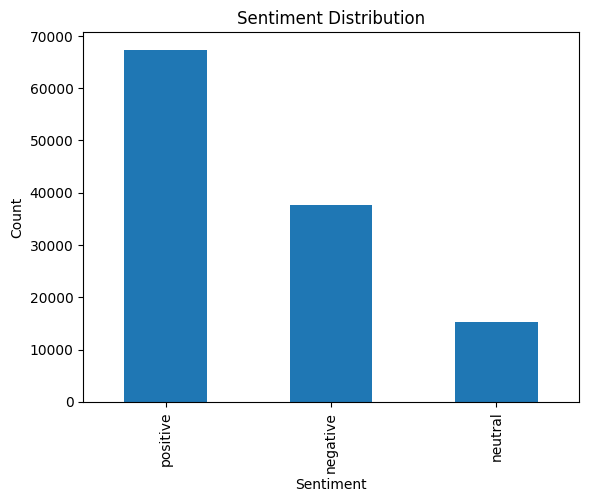

In [52]:


# Count the occurrences of each sentiment
sentiment_counts = netflix_reviews_df['sentiment'].value_counts()

# Plot the sentiment distribution
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


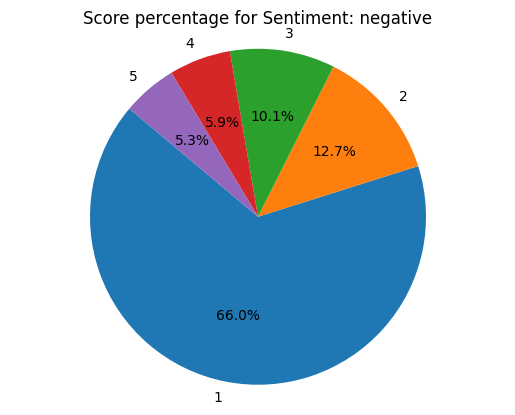

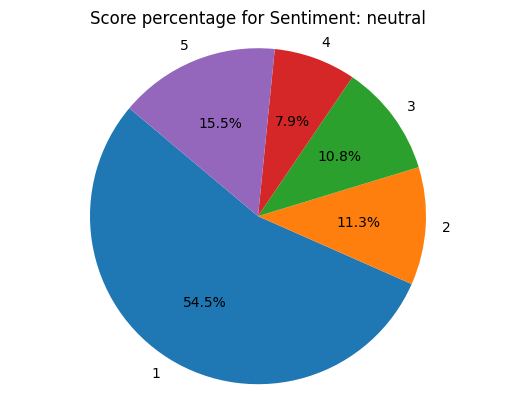

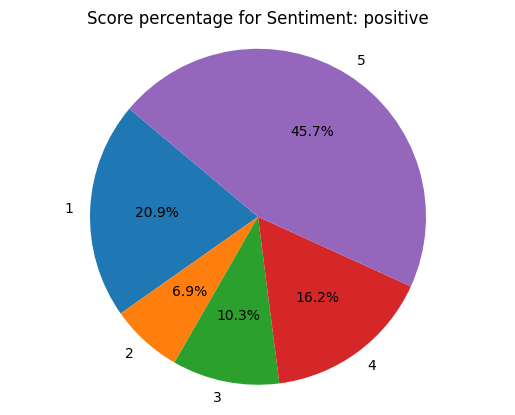

In [86]:
sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()

for sentiment in sentiment_score_counts.index:
    sentiment_counts = sentiment_score_counts.loc[sentiment]
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Score percentage for Sentiment: {sentiment}')
    plt.axis('equal') 
    plt.show()


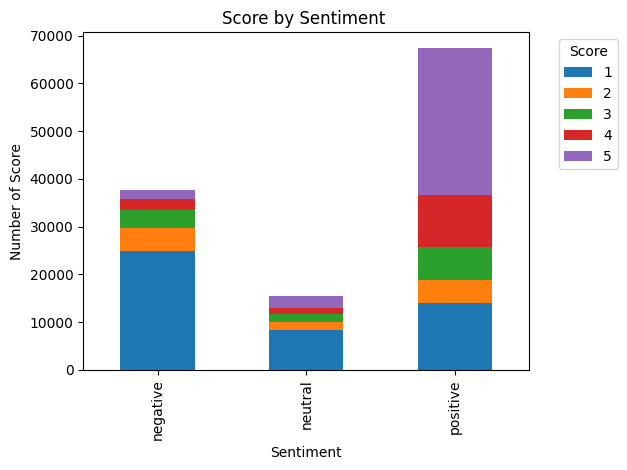

In [87]:
sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()
sentiment_score_counts.plot(kind='bar', stacked=True)

plt.title('Score by Sentiment ')
plt.xlabel('Sentiment')
plt.ylabel('Number of Score')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Text Data Preprocessing and Splitting for Model Training

In this step, we prepare the data for training a machine learning model. The following preprocessing steps are applied to the cleaned text data:

1. **Tokenization**: Convert text into a sequence of integers based on word frequency.
2. **Padding**: Ensure all sequences have the same length for model compatibility.
3. **Sentiment Label Mapping**: Convert sentiment labels (positive, neutral, negative) into numerical values and apply one-hot encoding.
4. **Data Splitting**: Divide the data into training and testing sets.


In [53]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [58]:

# Parameters
max_len = 100  # Max number of words in a sequence
max_features = 20000  # Top 20,000 words
test_size = 0.2  # 20% for testing

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(netflix_reviews_df['cleaned_content'])  # Use cleaned text content
sequences = tokenizer.texts_to_sequences(netflix_reviews_df['cleaned_content'])

# Pad the sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len)

# Convert sentiments to numerical labels
sentiment_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = netflix_reviews_df['sentiment'].map(sentiment_label_map).values

# Convert labels to one-hot encoding (for categorical cross-entropy loss)
y = to_categorical(y, num_classes=3)  # 3 classes: negative, neutral, positive

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Optionally, shuffle training data before model fitting
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Check the shapes to ensure everything is correct
print(X_train.shape)  # Expected: (num_samples, max_len)
print(y_train.shape)  # Expected: (num_samples, 3) for one-hot encoded labels


(96318, 100)
(96318, 3)


In [73]:
print(X_train.shape)  # Check the dimensions of X_train after padding
print(X_train[0])  # Check the first sequence to ensure it's not all zeros


(96318, 100)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   51  786   20   53   96   26
 1008    2   36   23  332   12 1624   52  148    2  108   14  535   15
    6 1437]


# Model Architecture: Convolutional Neural Network (CNN) with LSTM

This model is a hybrid architecture that combines **Convolutional Neural Networks (CNN)** and **Long Short-Term Memory (LSTM)** networks for sentiment classification. The objective of the model is to classify text data (in this case, Netflix reviews) into three sentiment categories: **negative**, **neutral**, and **positive**.

## 1. **Embedding Layer**
The embedding layer is the first layer in the model. It is used to convert integer-encoded words into dense vector representations. Each word in the input sequence is mapped to a fixed-size vector, capturing the semantic meaning of the word. This allows the model to process text data in a more informative format, enhancing its ability to recognize patterns in the text.

### Key Points:
- The embedding layer transforms each word into a vector of real numbers, which is more effective for understanding the relationships between words.
- It is typically used in text classification tasks to convert words into a format that a neural network can process.

## 2. **Conv1D Layer**
The Conv1D (1D Convolutional) layer helps to extract local features from the embedded word representations. It applies convolutional filters over the input sequences to capture short-term patterns in the data. These filters slide over the word sequences, detecting important local features such as specific phrases or structures in the text that are relevant for sentiment classification.

### Key Points:
- This layer is beneficial for capturing local features in the text, such as important word combinations or syntactic structures that indicate sentiment.
- The Conv1D layer learns filters that highlight meaningful patterns, which the network uses to classify the sentiment.

## 3. **MaxPooling1D Layer**
After the convolution operation, a max-pooling layer is applied to down-sample the feature maps. The max-pooling operation takes the maximum value from a fixed-size window and reduces the dimensionality of the feature maps. This helps in reducing the number of parameters, preventing overfitting, and making the model more efficient.

### Key Points:
- MaxPooling helps in reducing the complexity of the model by keeping only the most significant features, thus improving generalization.
- It allows the model to focus on the most important aspects of the extracted features, making it more robust.

## 4. **LSTM Layer**
The LSTM (Long Short-Term Memory) layer is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequences of data. This layer is particularly effective in natural language processing tasks because it can remember information over long sequences, which is important for understanding context and the meaning of a text.

### Key Points:
- The LSTM layer helps the model capture the overall context of the input text, taking into account the order and relationships of words in a sentence or document.
- It is useful for tasks where the meaning of a word is dependent on the words that came before or after it in the sequence.

## 5. **Dense Layer**
The dense layer is the final layer of the model, where the output from the previous layers is fed into fully connected neurons. The dense layer produces the final predictions of the model, outputting a probability distribution over the possible sentiment classes (negative, neutral, positive).

### Key Points:
- The dense layer uses the **softmax activation function** to output a probability for each sentiment class.
- It ensures that the sum of the output probabilities equals 1, which is typical for multi-class classification tasks.

This hybrid model combines the power of **Conv1D** for local feature extraction and **LSTM** for capturing long-term dependencies in text sequences. It is well-suited for sentiment analysis, as it can effectively identify both local and global patterns in text data, which is crucial for understanding sentiment.

The model architecture is structured to first convert words into dense vectors, extract relevant local features, capture long-term dependencies, and finally make a prediction about the sentiment of the text. This approach allows the model to achieve a deeper understanding of the text, leading to better performance in sentiment classification tasks.

-------------

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [74]:
# Define the model with Conv1D and LSTM
model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model.add(Conv1D(64, 5, activation='relu'))  # 64 filters, kernel size = 5
model.add(MaxPooling1D(5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: negative, neutral, positive

# Model summary
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

- **Loss Function: `categorical_crossentropy`**  
  This is used for multi-class classification problems, where each output is assigned to one of several possible categories. It calculates the difference between the predicted probability distribution and the true distribution.

- **Optimizer: `adam`**  
  The Adam optimizer is used to minimize the loss function. It combines the advantages of two other extensions of stochastic gradient descent, AdaGrad and RMSProp, and adapts the learning rate based on each parameter's updates.

- **Metrics: `accuracy`**  
  The model uses accuracy as the evaluation metric to track how often predictions match the true labels. It's commonly used for classification problems.

### Callbacks

- **EarlyStopping**  
  The EarlyStopping callback monitors the validation loss (`val_loss`) during training. If the validation loss does not improve for a specified number of epochs (patience = 3), training will stop early to prevent overfitting and save time.

- **ReduceLROnPlateau**  
  This callback reduces the learning rate by a factor of 0.2 if the validation loss stops improving for two consecutive epochs. This helps the model to refine its learning by decreasing the learning rate as the training progresses, avoiding overshooting the optimal minimum.

### Model Training (`fit`)

- **Training Data: `X_train`, `y_train`**  
  `X_train` represents the input features, while `y_train` represents the target labels (one-hot encoded for sentiment classes).

- **Epochs: `100`**  
  This specifies the number of complete passes through the training dataset. The model will iterate over the dataset 100 times unless early stopping halts training earlier.

- **Batch Size: `128`**  
  The batch size indicates how many samples are processed before updating the model weights. A batch size of 128 is commonly used for large datasets and strikes a balance between computation time and model convergence.

- **Validation Split: `0.2`**  
  The model will use 20% of the training data for validation during training. This helps in evaluating the model's performance on unseen data while it trains on the remaining 80%.

- **Callbacks: `early_stopping` and `lr_scheduler`**  
  These callbacks are passed to the `fit` method to be used during the training process. They help in improving training efficiency and performance.


In [75]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks (early stopping and learning rate scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 63s 99ms/step - accuracy: 0.7028 - loss: 0.6796 - val_accuracy: 0.8469 - val_loss: 0.4058 - learning_rate: 0.0010
Epoch 2/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 59s 97ms/step - accuracy: 0.8714 - loss: 0.3634 - val_accuracy: 0.8675 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 3/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.8964 - loss: 0.2962 - val_accuracy: 0.8639 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 4/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.9146 - loss: 0.2490 - val_accuracy: 0.8660 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 5/100
602/602 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.9336 - loss: 0.1984 - val_accuracy: 0.8687 - val_loss: 0.4182 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


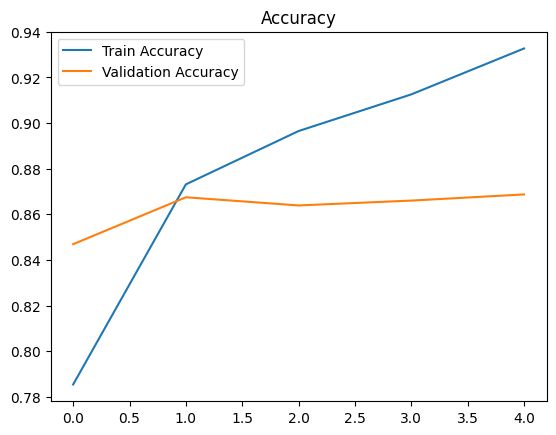

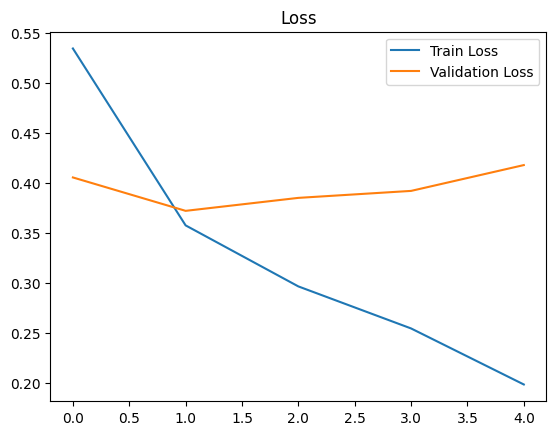

In [76]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


### Insights and Conclusion

- **Training vs. Validation:**  
  The model shows significant improvement in training accuracy with each epoch, but there is still some gap between training and validation performance. This suggests the model is overfitting slightly, as indicated by the higher training accuracy and relatively lower validation accuracy.

- **Learning Rate Adjustment:**  
  The learning rate is dynamically adjusted during training, reducing from 0.001 to 0.0002 by epoch 5. This helps the model to converge more effectively in later stages of training.

- **Overfitting Prevention:**  
  Early stopping was effectively employed to prevent overfitting. This ensures the model doesn't continue training when it no longer improves, saving computational resources and enhancing generalization.

  ------------

<h3>Evaluate the Model</h3>

In [77]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8650 - loss: 0.3775
Test Loss: 0.3795202076435089
Test Accuracy: 0.8646179437637329


753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


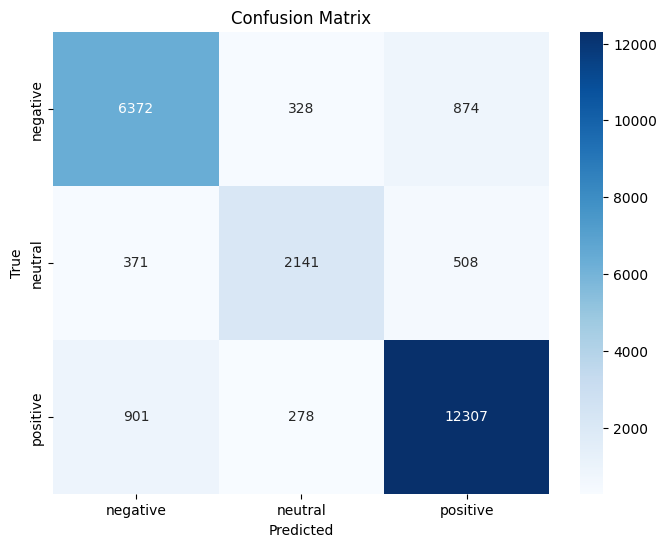

Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.84      0.84      7574
     neutral       0.78      0.71      0.74      3020
    positive       0.90      0.91      0.91     13486

    accuracy                           0.86     24080
   macro avg       0.84      0.82      0.83     24080
weighted avg       0.86      0.86      0.86     24080



In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the sentiment on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert true labels (y_test) from one-hot encoding to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Classification Report
class_report = classification_report(y_true_labels, y_pred_labels, target_names=['negative', 'neutral', 'positive'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print("Classification Report:\n", class_report)


### Conclusion

The classification model trained with Conv1D and LSTM layers has shown strong performance on the sentiment analysis task. The key insights based on the classification report are:

- **Precision, Recall, and F1-Score:**
  - **Negative Class:** The model achieved a precision of 0.83, recall of 0.84, and F1-score of 0.84. This indicates that the model is able to correctly identify negative sentiment with a reasonable level of accuracy while also minimizing false negatives.
  - **Neutral Class:** For the neutral sentiment, the model's precision is 0.78, recall is 0.71, and F1-score is 0.74. Although the performance on the neutral class is lower compared to negative and positive classes, it is still acceptable. There is room for improvement in recognizing neutral sentiment more effectively.
  - **Positive Class:** The positive class is the strongest, with a precision of 0.90, recall of 0.91, and F1-score of 0.91. The model performs exceptionally well in detecting positive sentiment, making it the most confident prediction class.

- **Overall Accuracy:**  
  The model achieved an overall accuracy of 86%. This demonstrates that the model is successful in correctly classifying a significant proportion of the data, but there is still some room for improvement, especially in the classification of neutral sentiments.

- **Macro Average:**  
  The macro average F1-score of 0.83 shows that the model performs well across all classes, with slightly higher performance in identifying positive sentiments.

- **Weighted Average:**  
  The weighted F1-score of 0.86 suggests that the model balances performance across classes well, with more emphasis placed on the positive class due to its higher support (larger number of samples).

### Final Thoughts

The model has successfully learned to classify sentiments with a high degree of accuracy, particularly in the positive and negative categories. However, further tuning may be needed to improve the classification of neutral sentiments. Potential improvements could involve:
- **Data Augmentation** for the neutral class to increase model sensitivity.
- **Hyperparameter tuning** to adjust the model architecture and learning rates further for better overall performance.
  
Despite these challenges, the model performs robustly in identifying both positive and negative sentiments, making it suitable for real-world applications in sentiment analysis.

The combination of Conv1D, MaxPooling1D, and LSTM in this model demonstrates the effectiveness of hybrid approaches for text classification tasks. With further refinements, this model can be optimized for production-level applications.


-----------